In [40]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

# load data and basic visualization
df_boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
df_boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv')
df_boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')

# Look At The Data

In [41]:
# look at the data 1/3 datasets
print(df_boston_calendar.columns)
df_boston_calendar.describe()

Index(['listing_id', 'date', 'available', 'price'], dtype='object')


,listing_id
count,1.308890e+06
mean,8.442118e+06
std,4.500149e+06
min,3.353000e+03
25%,4.679319e+06
50%,8.578710e+06
75%,1.279603e+07
max,1.493346e+07


In [42]:
# stranger thing over calendar prices, 50% of missing
df_boston_calendar.isna().mean()

listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64

In [43]:
# values of "available" columns
df_boston_calendar['available'].value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [44]:
# check for relation between availability and prices. Seems that prices are reported only when "available" is True.
df_boston_calendar[df_boston_calendar['available'] == 't']['price'].isna().mean()

0.0

##### Somethings strange about the "price" and "available" columns. I want to have prices as floats, and availability can be a boolenan or int 0, 1. But before fix these issues, check also the other datasets to find common errors and provided a unique routine to fix them, in case.  Moreover, prices are only reported when availability if "t" (true), keep this in mind for further analysis.

In [45]:
# look at the data 2/3 datasets
print(df_boston_listings.columns)
df_boston_listings.describe()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,0.000000e+00,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


In [46]:
# find all-nan columns, these can be droped
df_boston_listings.columns[df_boston_listings.isna().mean() == 1]
# wait drop belowe
#to_drop = df_boston_listings.columns[df_boston_listings.isna().mean() == 1]
#df_boston_listings.drop(columns=to_drop, inplace=True)

Index(['neighbourhood_group_cleansed', 'has_availability', 'license',
       'jurisdiction_names'],
      dtype='object')

In [47]:
# check listings prices in listings dataset. same problem as above
price_columns = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_boston_listings[price_columns]

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$250.00,NaN,NaN,NaN,$35.00,$0.00
1,$65.00,$400.00,NaN,$95.00,$10.00,$0.00
2,$65.00,$395.00,"$1,350.00",NaN,NaN,$20.00
3,$75.00,NaN,NaN,$100.00,$50.00,$25.00
4,$79.00,NaN,NaN,NaN,$15.00,$0.00
...,...,...,...,...,...,...
3580,$69.00,NaN,NaN,$95.00,NaN,$24.00
3581,$150.00,NaN,NaN,$100.00,$15.00,$0.00
3582,$198.00,NaN,NaN,NaN,NaN,$0.00
3583,$65.00,NaN,NaN,$100.00,NaN,$30.00


In [48]:
df_boston_listings[price_columns].isna().mean()

price               0.000000
weekly_price        0.751185
monthly_price       0.752301
security_deposit    0.625662
cleaning_fee        0.308787
extra_people        0.000000
dtype: float64

As said, price in this dataset present the same problem. May missing values for weekly and monthly prices.

In [49]:
# look at the data 3/3 datasets
print(df_boston_reviews.columns)
df_boston_reviews.describe()

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


,listing_id,id,reviewer_id
count,6.827500e+04,6.827500e+04,6.827500e+04
mean,4.759910e+06,5.246516e+07,2.802389e+07
std,3.788990e+06,2.790991e+07,2.234097e+07
min,3.353000e+03,1.021000e+03,1.430000e+02
25%,1.458081e+06,3.010420e+07,9.001346e+06
50%,4.080000e+06,5.223121e+07,2.305179e+07
75%,7.377034e+06,7.663248e+07,4.213454e+07
max,1.484378e+07,9.999045e+07,9.335034e+07


In [50]:
# no problem with missing values, just minor missing in comments, let's handle this furtehr on is needed
df_boston_reviews.isna().mean()

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000776
dtype: float64

In [51]:
# number of listings over each date
df_boston_calendar.groupby('date').count()['available'].value_counts()

3586    365
Name: available, dtype: int64

In [171]:
for col in ['neighbourhood']:
    print(col)
    print(df_boston_listings[col].iloc[0:2])

neighbourhood
0    Roslindale
1    Roslindale
Name: neighbourhood, dtype: object


In [53]:
# drop unusable columns, keep id to use as reference among listings and calendar
cols_to_drop = ['listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 'experiences_offered', 
                'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 
                'host_about', 'host_total_listings_count', 'street', 'neighbourhood_cleansed',
                 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 
                'latitude', 'longitude', 'is_location_exact', 'has_availability', 'neighbourhood_group_cleansed', 
                'square_feet', 'weekly_price', 'monthly_price', 'maximum_nights', 
                'calendar_updated', 'availability_30', 'availability_60', 'availability_90',
                'availability_365', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 
                'license', 'jurisdiction_names', 'reviews_per_month', 
                'require_guest_profile_picture', 'require_guest_phone_verification', 
                'calculated_host_listings_count', 'host_thumbnail_url', 'host_picture_url']

df_boston_listings = df_boston_listings.drop(columns=cols_to_drop)

# drop all nan columns, if any remains
df_boston_listings.dropna(axis=1, how='all', inplace=True)

"""
id -> kept
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered -> all none''
neighborhood_overview -> description, nedd advacned analysis to extract usaful features
neighbourhood_group_cleansed -> all nan
notes -> descriptions
transit -> as above
access -> as above
interaction -> as above
house_rules -> as above
thumbnail_url
medium_url
picture_url
xl_picture_url
host_url
host_about
host_thumbnail_url
host_picture_url
host_has_profile_pic
street -> not used now, in future georeference
host_total_listings_count -> same values of host_listings_count
neighbourhood_cleansed
city, -> not used now, in future georeference
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
square_feet - could be used to evaluate the property size but most of the values are missing
weekly_price - mostly blank so we will use price instead
monthly_price - mostly blank so we will use price instead
maximum_nights - most of the values are above 30 days suggesting its used as an open bracket
calendar_updated - we are not interested in future data that is a subject to daily updates
has_availability - as above, all nan
availability_30 - as above
availability_60 - as above
availability_90 - as above
availability_365 - as above
calendar_last_scraped - as above
first_review
last_review, 
review_scores_rating [kept] - this value is calculated as weighted sum of other scores
requires_license - all values are t
license - textual value that is mostly null
jurisdiction_names - contains only nulls
reviews_per_month
calculated_host_listings_count
require_guest_profile_picture
require_guest_phone_verification
"""
df_boston_listings.head()

,id,last_scraped,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
0,12147973,2016-09-07,31303940,2015-04-15,"Boston, Massachusetts, United States",NaN,NaN,NaN,f,Roslindale,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate
1,3075044,2016-09-07,2572247,2012-06-07,"Boston, Massachusetts, United States",within an hour,100%,100%,f,Roslindale,...,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,t,moderate
2,6976,2016-09-07,16701,2009-05-11,"Boston, Massachusetts, United States",within a few hours,100%,88%,t,Roslindale,...,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,moderate
3,1436513,2016-09-07,6031442,2013-04-21,"Boston, Massachusetts, United States",within a few hours,100%,50%,f,NaN,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate
4,7651065,2016-09-07,15396970,2014-05-11,"Boston, Massachusetts, United States",within an hour,100%,100%,t,Roslindale,...,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,f,flexible


In [54]:
for col in df_boston_listings.columns:
    print(df_boston_listings[col].iloc[0:10])
    
# percentage to float: 'host_response_rate', 'host_acceptance_rate', ''

0    12147973
1     3075044
2        6976
3     1436513
4     7651065
5    12386020
6     5706985
7     2843445
8      753446
9      849408
Name: id, dtype: int64
0    2016-09-07
1    2016-09-07
2    2016-09-07
3    2016-09-07
4    2016-09-07
5    2016-09-07
6    2016-09-07
7    2016-09-07
8    2016-09-07
9    2016-09-07
Name: last_scraped, dtype: object
0    31303940
1     2572247
2       16701
3     6031442
4    15396970
5    64200298
6     6570877
7     3164508
8     3962517
9     4434391
Name: host_id, dtype: int64
0    2015-04-15
1    2012-06-07
2    2009-05-11
3    2013-04-21
4    2014-05-11
5    2016-03-23
6    2013-05-25
7    2012-08-05
8    2012-10-24
9    2012-12-18
Name: host_since, dtype: object
0    Boston, Massachusetts, United States
1    Boston, Massachusetts, United States
2    Boston, Massachusetts, United States
3    Boston, Massachusetts, United States
4    Boston, Massachusetts, United States
5    Boston, Massachusetts, United States
6    Milton, Massachusetts, Uni

### Fix columns ("prices", "available", etc)

In [67]:
def replace_categorical_true_false(df, cols):
    """ replace cell values t/f to 0/1
    INPUTS:
     - df: a dataframe of data
     - cols: the columns to apply the replace
    OUTPUTS:
     - new dataframe with replaced values
    """
    
    # convert t/f categorical to 0/1
    for col in  cols:
        df[col].replace('t', 1, inplace=True)
        df[col].replace('f', 0, inplace=True)
        
    return df


# function to fix prices removing $ and converting to float the string number
def fix_price(df, cols, fill_na=True):
    """ Convert price in string format to float
    
    INPUTS:
        - df: dataframe with columns to fix. 
                Example: cell with string "$100.00" converted to cell with float 100.0 
        - cols: the columns to apply the fix
        - fill_na: flag to replace remaing NaN values with 0.
    OUTPUTS:
        - the input df with the prices fixed.
    """
    
    for col in cols:
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

    if fill_na:
        df = df.fillna(0)
    
    return df

# function to fix percentage in string format: removing % and converting to float the string number
def fix_percentage(df, cols, fill_na=True):
    """ Convert percentage in string format to float
    
    INPUTS:
        - df: dataframe with columns to fix. 
                Example: cell with string "100%" converted to cell with float 100.0 
        - cols: the columns to apply the fix
        - fill_na: flag to replace remaing NaN values with 0.
    OUTPUTS:
        - the input df with the percentages fixed.
    """
    
    for col in cols:
            df[col] = df[col].replace('[\%,]', '', regex=True).astype(float)

    if fill_na:
        df = df.fillna(0)
    
    return df


# replace t/w with 0/1 
listings_columns_with_true_false = ['host_is_superhost', 'host_has_profile_pic', 'host_has_profile_pic', 'host_has_profile_pic']
df_boston_listings = replace_categorical_true_false(df_boston_listings, listings_columns_with_true_false)

calendar_columns_with_true_false = ['available']
df_boston_calendar = replace_categorical_true_false(df_boston_calendar, calendar_columns_with_true_false)

# fix price
price_columns = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_boston_listings = fix_price(df_boston_listings, price_columns, False)
df_boston_calendar = fix_price(df_boston_calendar, ['price'], False)

# fix percentage
listings_columns_with_percentage = ['host_response_rate', 'host_acceptance_rate']
df_boston_listings = fix_percentage(df_boston_listings, listings_columns_with_percentage, False)

# now looks fine
all_fixed_columns = listings_columns_with_true_false
all_fixed_columns.extend(price_columns)
all_fixed_columns.extend(listings_columns_with_percentage)


# now looks fine
df_boston_listings[all_fixed_columns].head()

,host_is_superhost,host_has_profile_pic,host_has_profile_pic,host_has_profile_pic,price,security_deposit,cleaning_fee,extra_people,host_response_rate,host_acceptance_rate
0,0,1,1,1,250.0,NaN,35.0,0.0,NaN,NaN
1,0,1,1,1,65.0,95.0,10.0,0.0,100.0,100.0
2,1,1,1,1,65.0,NaN,NaN,20.0,100.0,88.0
3,0,1,1,1,75.0,100.0,50.0,25.0,100.0,50.0
4,1,1,1,1,79.0,NaN,15.0,0.0,100.0,100.0


## Let's start with analyze price rates

In [68]:
# What is the diff between calendar prices and listing prices? Listing prices are fixed, the calendar prices can change?
# first of all, get mean price of only available period (==1)
mean_prices_calendar = df_boston_calendar.groupby('listing_id').mean()['price']
df_boston_listings_indexed = df_boston_listings.set_index('id')  # use listing id as index
df_merge = pd.merge(df_boston_listings_indexed['price'], mean_prices_calendar, left_index=True, right_index=True)
df_merge.columns = ['price_listing', 'price_calendar']
df_merge['diff_perc'] = 1 - (df_merge['price_calendar'] / df_merge['price_listing'])
df_merge['diff_perc'].describe()
print(f"Listings with unchanged price: {len(df_merge[df_merge['diff_perc'] == 0])}")
print(f"Listings with changed price: {len(df_merge[df_merge['diff_perc'] != 0])}")
print(f"Total number of listings: {len(df_merge)}")

Listings with unchanged price: 906
Listings with changed price: 2679
Total number of listings: 3585


### Availability vs Price
 Previous observations confirm changes of the prices during the observation periods. Let's compare availability vs price to get the dates wiht the higher price changes and to find the busiest period.

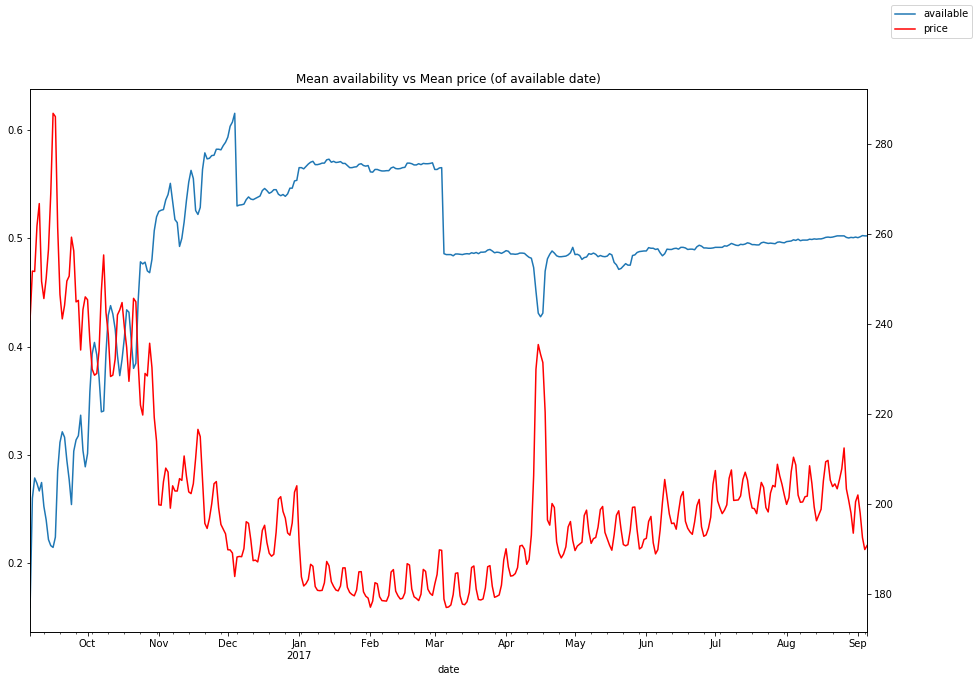

In [69]:
# find the busiest days/week of the year
df_boston_calendar['date'] = pd.to_datetime(df_boston_calendar['date'])
grouby_date = df_boston_calendar.groupby(['date'])
#num_listing_over_time = grouby_date['listing_id'].count()
#aviability_over_time = grouby_date['available'].sum()
#(aviability_over_time / num_listing_over_time).plot(rot=30, title='Ratio availability / # of listings');

# avg weekly availability
#listing_available_in_date = grouby_date.count()['price']
listing_available_in_date = grouby_date.mean()['available']
mean_price_of_listing_available_in_date = grouby_date.mean()['price']
ax = listing_available_in_date.plot(legend=False, title='Mean availability vs Mean price (of available date)', label='available')
ax2 = ax.twinx()
mean_price_of_listing_available_in_date.plot(ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [72]:
# add day of week, weekly and monthly aggregation
# prepara data creating dayofweek, week, month columns using the info in the date/index
listing_available_in_date_df = grouby_date.mean()
listing_available_in_date_df['dayofweek'] = listing_available_in_date_df.index.day_name()
listing_available_in_date_df['week'] = listing_available_in_date_df.index.week
listing_available_in_date_df['month'] = listing_available_in_date_df.index.month_name()
listing_available_in_date_df.head(20)

,listing_id,available,price,dayofweek,week,month
date,,,,,,
2016-09-06,8.442118e+06,0.158951,241.043860,Tuesday,36,September
2016-09-07,8.442118e+06,0.259900,251.833691,Wednesday,36,September
2016-09-08,8.442118e+06,0.278583,251.748749,Thursday,36,September
2016-09-09,8.442118e+06,0.273564,261.859327,Friday,36,September
2016-09-10,8.442118e+06,0.266592,266.847280,Saturday,36,September
2016-09-11,8.442118e+06,0.274400,249.565041,Sunday,36,September
2016-09-12,8.442118e+06,0.252370,245.732597,Monday,37,September
2016-09-13,8.442118e+06,0.239822,250.206977,Tuesday,37,September
2016-09-14,8.442118e+06,0.221695,256.647799,Wednesday,37,September


DatetimeIndex(['2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09',
               '2016-09-10', '2016-09-11', '2016-09-12', '2016-09-13',
               '2016-09-14', '2016-09-15',
               ...
               '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
               '2017-08-31', '2017-09-01', '2017-09-02', '2017-09-03',
               '2017-09-04', '2017-09-05'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)

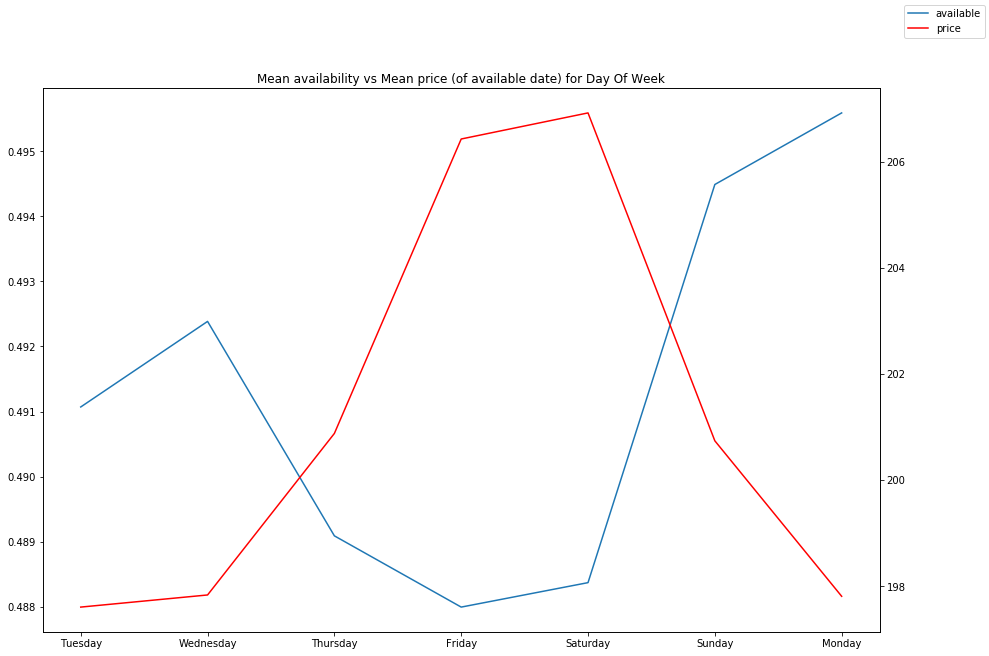

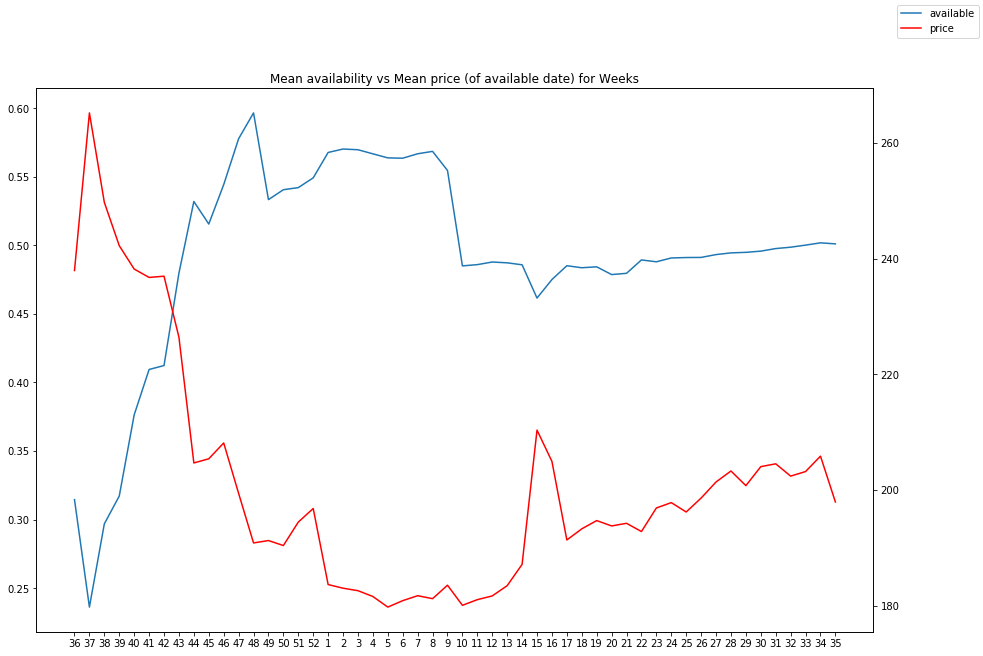

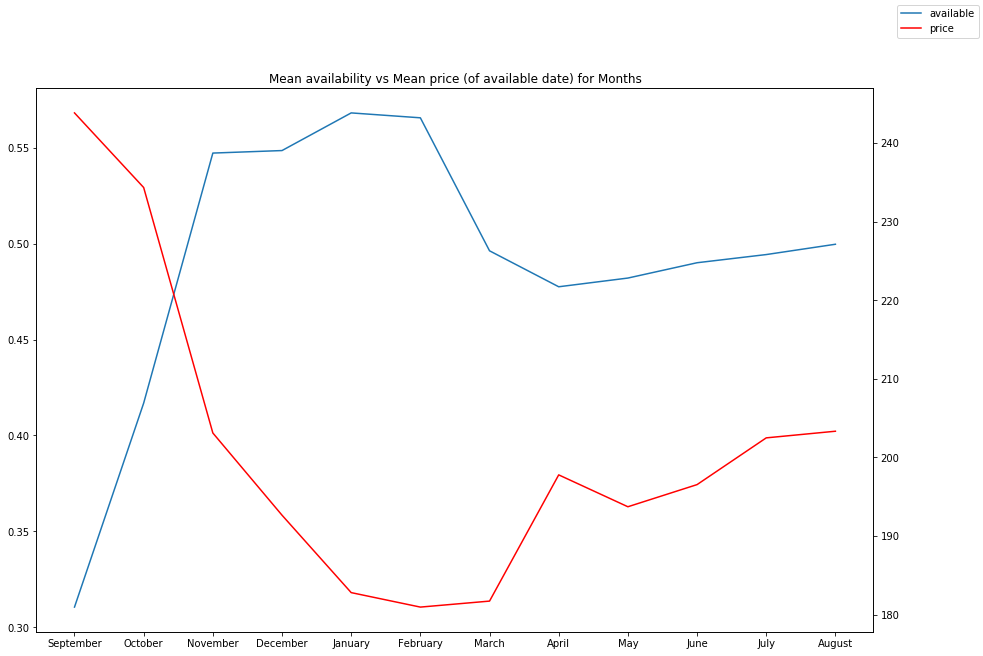

In [110]:
# function to plot the aggregated data
def plot_price_and_avail_per_aggregation(df, groupby_colums, prefix_title):
    """ Dispaly the plot of the aggregated data
    INPUTS:
     - df: dataframe with the data to group
     - groupby_colums: column to use as group of the groupby
     - prefix_title: string to use in the plot title
    """
    
    df_index = list(df[groupby_colums].unique())
    group_df = df.groupby(groupby_colums).mean().reindex(df_index)

    ax = group_df.plot(y='available', legend=False, use_index=False, title=f'Mean availability vs Mean price (of available date) for {prefix_title}')
    # this trick avoid to sort the xticklabels and keep the index sort, mainly for "week"
    ax.set_xticks(range(len(df_index)))
    ax.set_xticklabels(df_index)
    ax2 = ax.twinx()
    group_df.plot(ax=ax2, y='price', legend=False, color="r", use_index=False)
    ax.figure.legend()
    plt.show()

plot_price_and_avail_per_aggregation(listing_available_in_date_df, 'dayofweek', 'Day Of Week')
plot_price_and_avail_per_aggregation(listing_available_in_date_df, 'week', 'Weeks')
plot_price_and_avail_per_aggregation(listing_available_in_date_df, 'month', 'Months')

#### Beside an initial transitory period (opposite trends for prices -deincreasing, and overall availability - increasing), a plateau is reached around the begining of 2017. Around April a spike is present in both prices and availabilities, but put together all the properties types not seem the right way to conduct this analysis.   

#### The day of the week denotes a that weekends are periods with higher prices and lower in availbility. The weekly aggregation denotes the higher prices from Sept to almosto Dec, and allows to highlight  the spike at the half of April, together with a drastic reduction of the availability. Finally, the monthly aggregation follows the trend, even if smoth, of the weekly aggregation.

##### Note: the number of listings has been always the same, over 365 days always 3586 listing.

### Try to decompose in properties by price ranges
Price range is really wide and altought a clear spike in the spring-break is notable for the price rates, together with a markerd reduction of the availability, is it possible to have better resoltuion of what happens by some type of classification by typololgies of listings? Therefore, first of all, we define 3 main categories based on the price distribution. Low > 0.33% quantile, Mid 0.33-0.66% quantile, High > 0.66% quantile.
In order to produce comparable results over availabilities and prices, for each category a min-max normalization is performed over values in 'available' and 'price' columns.

In [120]:
# find 3 cat of apartments based on prices distribution, using the prices in listing dataset
df_boston_listings['price'].describe([0.33, 0.66, 1])

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
33%       100.000000
50%       150.000000
66%       195.000000
100%     4000.000000
max      4000.000000
Name: price, dtype: float64

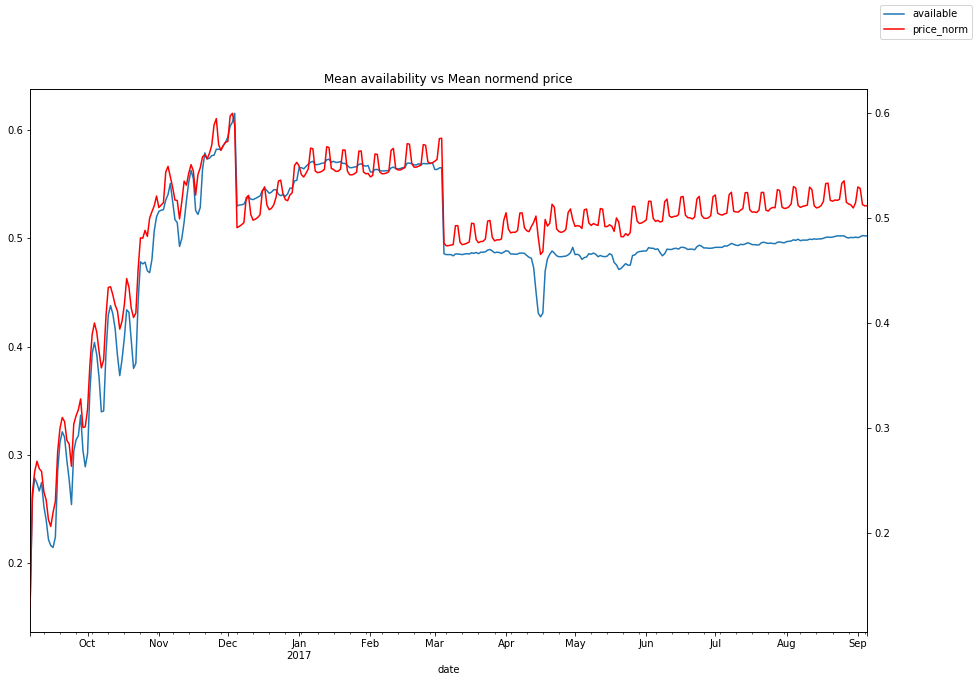

,listing_id,available,price,price_norm,dayofweek,week,month
date,,,,,,,
2016-09-06,8.442118e+06,0.158951,38.314278,0.129413,Tuesday,36,September
2016-09-07,8.442118e+06,0.259900,65.451478,0.238157,Wednesday,36,September
2016-09-08,8.442118e+06,0.278583,70.133017,0.258632,Thursday,36,September
2016-09-09,8.442118e+06,0.273564,71.635248,0.268527,Friday,36,September
2016-09-10,8.442118e+06,0.266592,71.139431,0.261548,Saturday,36,September
2016-09-11,8.442118e+06,0.274400,68.480759,0.258842,Sunday,36,September
2016-09-12,8.442118e+06,0.252370,62.015616,0.239516,Monday,37,September
2016-09-13,8.442118e+06,0.239822,60.005020,0.231622,Tuesday,37,September
2016-09-14,8.442118e+06,0.221695,56.897658,0.212851,Wednesday,37,September


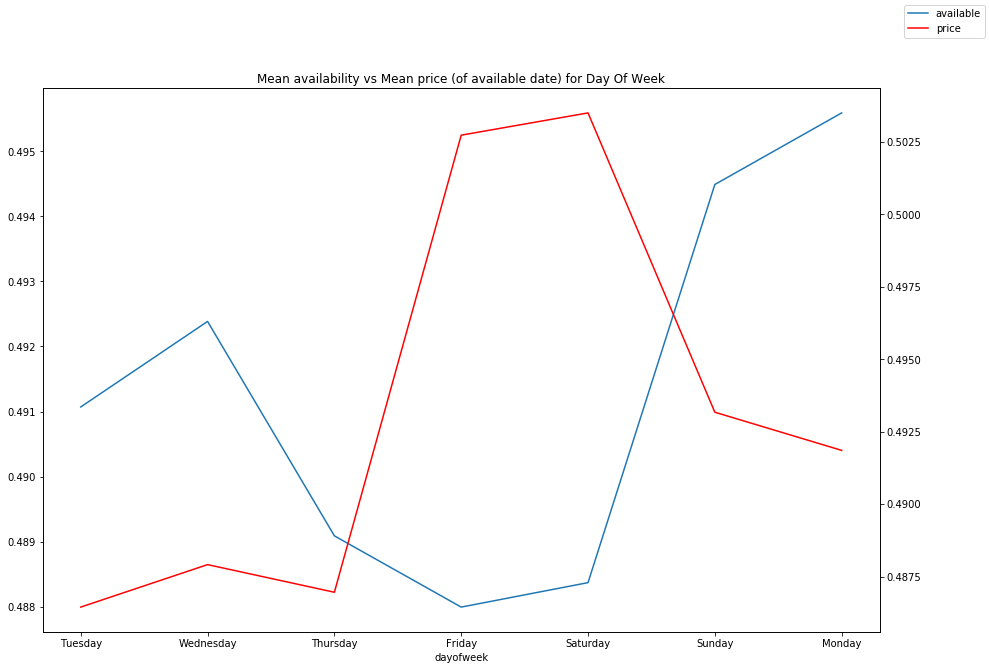

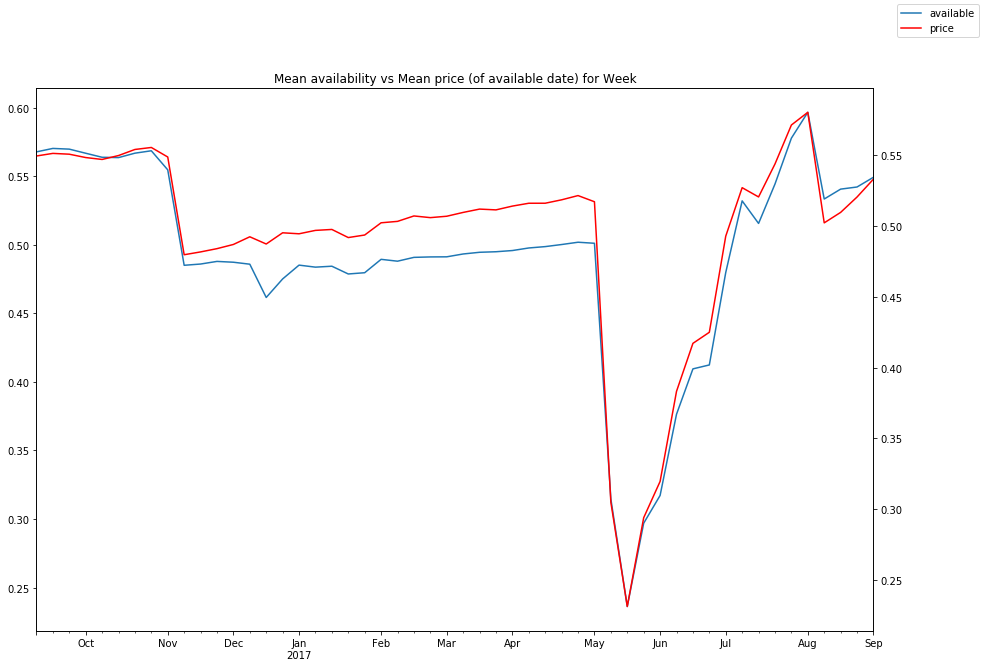

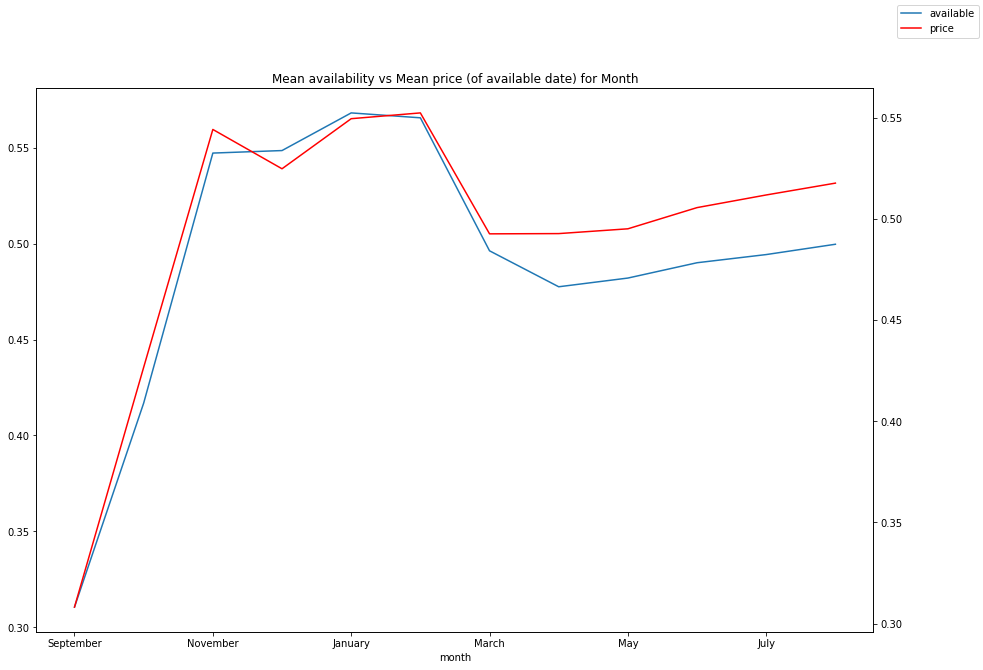

#### Normalizing the price data allows to really see as prices (normalized) chanegs over the year. At this point the spike in April is confirmed and must be analyzed 

#### Analyze price and availability per apartament categories (0.33, 0.66, 1 quantile)  

In [125]:
# from prices in listing, here the 3 categories selected. A quick view over the numebr of properties per cat.
cat1 = [0, 100]  # LOW
cat2 = [100, 195]  # MID
cat3 = [195, 4000]  # HIGH
# mean price of the only available day
groupby_mean_price = df_boston_calendar.groupby('listing_id').mean()['price']
#cat1_listings = groupby_mean_price[groupby_mean_price <= cat1[1]].index
#cat2_listings = groupby_mean_price[(groupby_mean_price > cat2[0]) & (groupby_mean_price <= cat2[1])].index
#cat3_listings = groupby_mean_price[groupby_mean_price > cat3[0]].index]
cat1_listings = df_boston_listings[df_boston_listings['price'] <= cat1[1]]['id']
cat2_listings = df_boston_listings[(df_boston_listings['price'] > cat2[0]) & (df_boston_listings['price'] <= cat2[1])]['id']
cat3_listings = df_boston_listings[df_boston_listings['price'] > cat3[0]]['id']
print(f"Cat 1 listings: {len(cat1_listings)} - {cat1}")
print(f"Cat 2 listings: {len(cat2_listings)} - {cat2}")
print(f"Cat 3 listings: {len(cat3_listings)} - {cat3}")
print(f"Overall listings: {len(groupby_mean_price)}")
print(f"Listings with missing price: {groupby_mean_price.isna().sum()}")
df_cat1 = df_boston_calendar[df_boston_calendar['listing_id'].isin(cat1_listings)]
df_cat2 = df_boston_calendar[df_boston_calendar['listing_id'].isin(cat2_listings)]
df_cat3 = df_boston_calendar[df_boston_calendar['listing_id'].isin(cat3_listings)]

Cat 1 listings: 1252 - [0, 100]
Cat 2 listings: 1133 - [100, 195]
Cat 3 listings: 1200 - [195, 4000]
Overall listings: 3585
Listings with missing price: 679


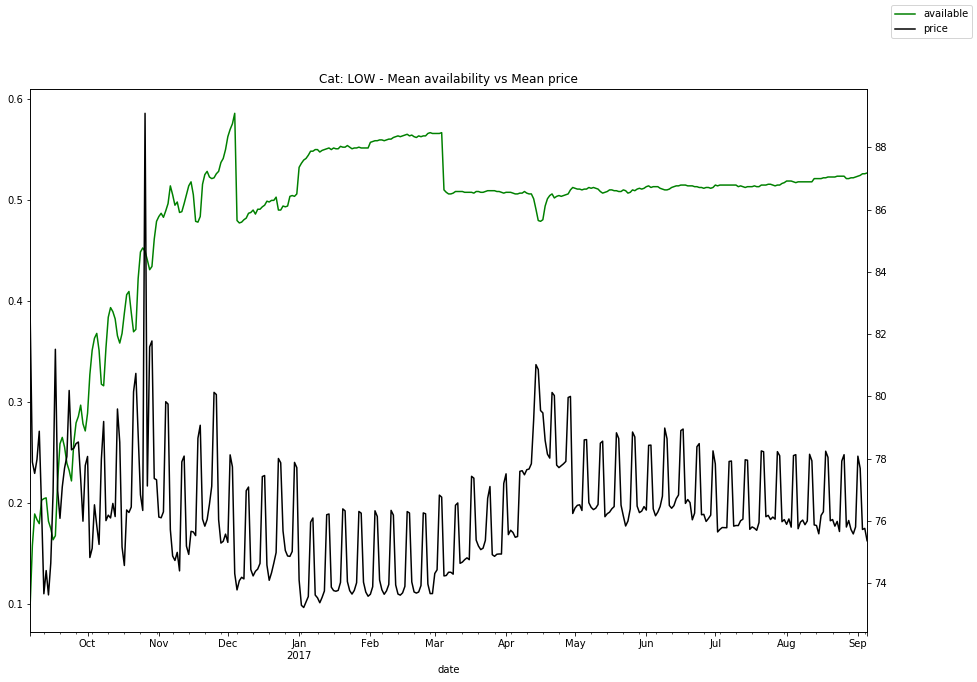

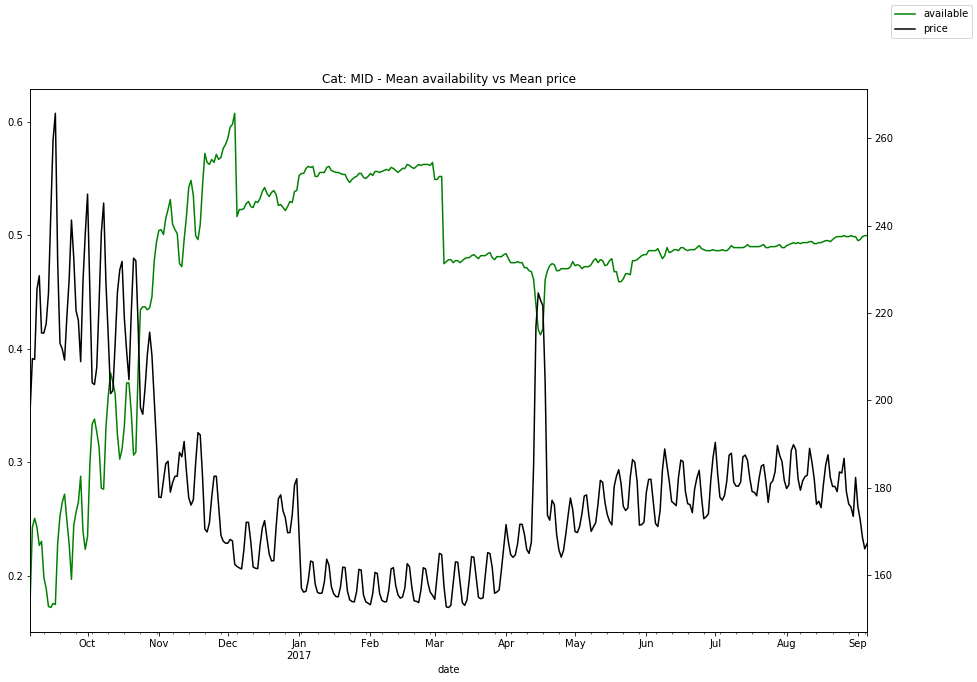

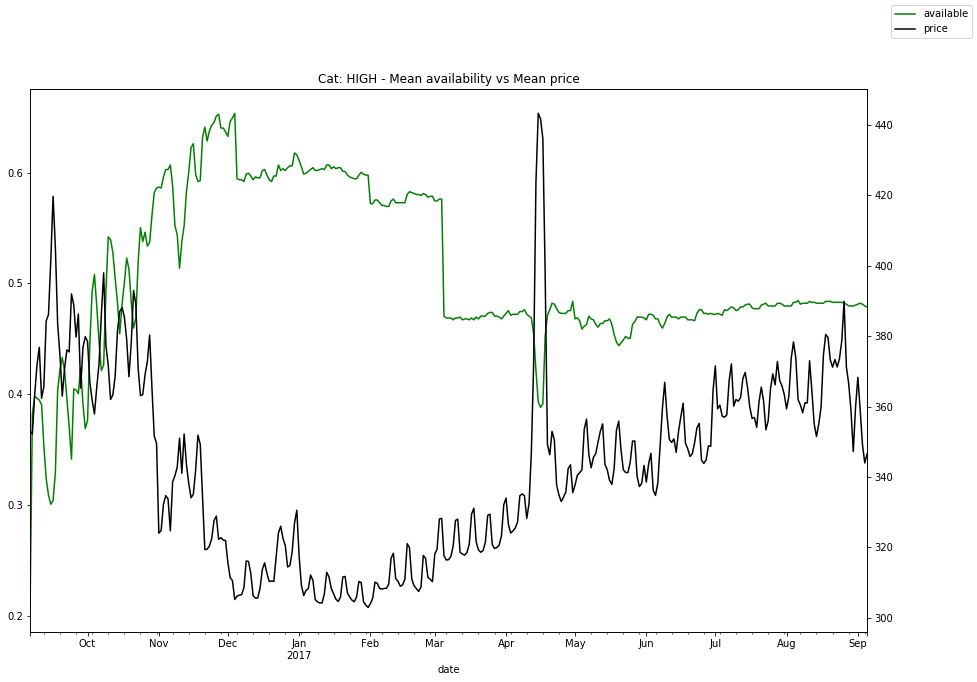

In [126]:
# normalize and plot over categories

def min_max_normalization(input_series):
    return (input_series - input_series.min()) / (input_series.max() - input_series.min()) 

grouby_date_cat1 = df_cat1.groupby('date').mean()
grouby_date_cat2 = df_cat2.groupby('date').mean()
grouby_date_cat3 = df_cat3.groupby('date').mean()

# plt cat LOW
ax = grouby_date_cat1.plot(legend=False, color='g', y='available', title='Cat: LOW - Mean availability vs Mean price')
ax2 = ax.twinx()
grouby_date_cat1.plot(y="price", ax=ax2, legend=False, color='black')
ax.figure.legend()
plt.show()

# plt cat MID
ax = grouby_date_cat2.plot(legend=False, color='g', y='available', title='Cat: MID - Mean availability vs Mean price')
ax2 = ax.twinx()
grouby_date_cat2.plot(y="price", ax=ax2, legend=False, color='black')
ax.figure.legend()
plt.show()

# plt cat HIGH
ax = grouby_date_cat3.plot(legend=False, color='g', y='available', title='Cat: HIGH - Mean availability vs Mean price')
ax2 = ax.twinx()
grouby_date_cat3.plot(y="price", ax=ax2, legend=False, color='black')
ax.figure.legend()
plt.show()

### The separation of the properties by price rates allows to highlight that the spinrg break spike produce a major absolute increasing in the MID and HIGH categories. The LOW category seems to keep more stabe price rates, and a reduced price range: lower 74, upper 88. The MID has a range from 155 to 260. Finally, the high from 300 to 440.

### Let's observe the aggregated date by day of the week weeks and months for the 3 catergies.

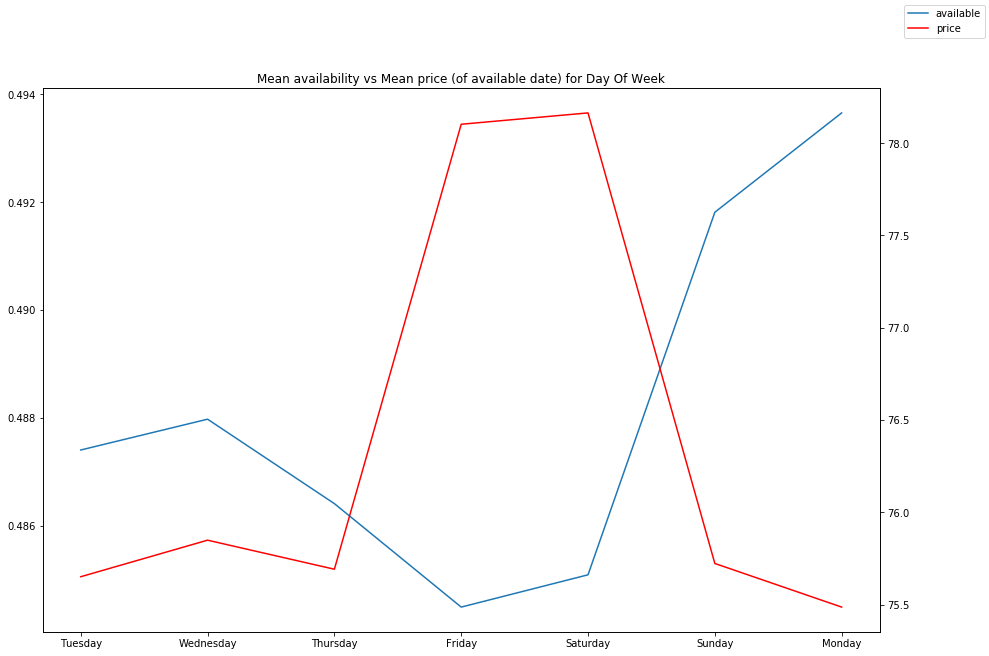

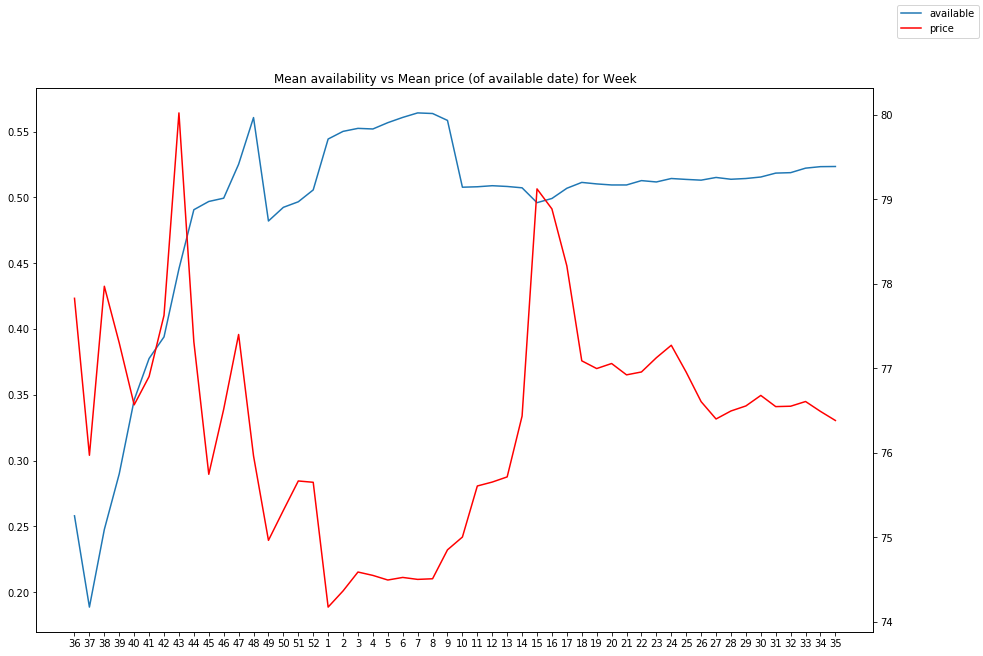

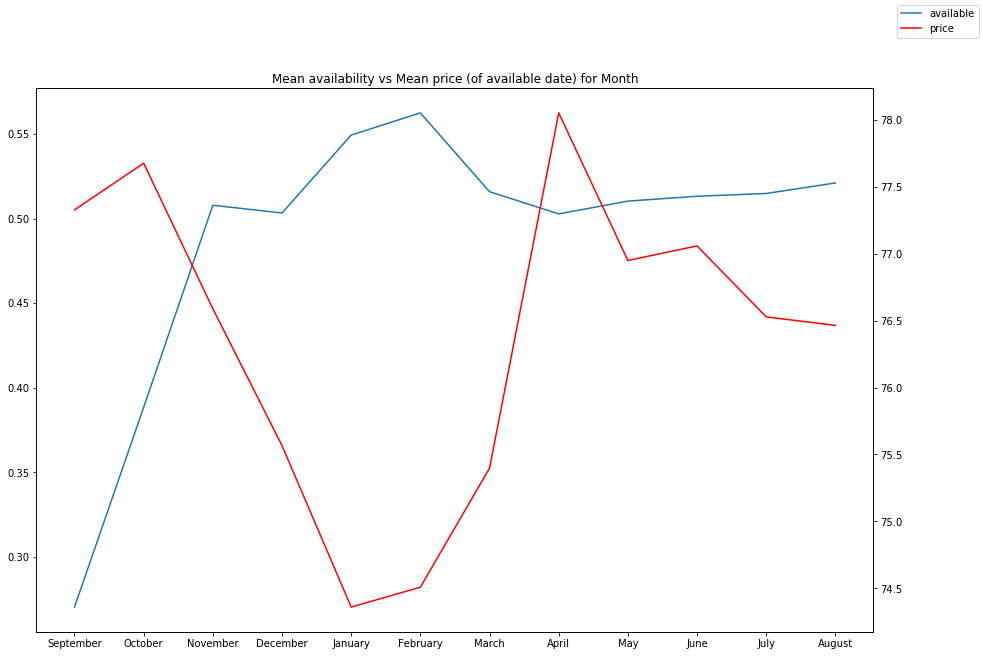

In [131]:
cat1_listing_available_in_date_df = grouby_date_cat1.copy()
cat1_listing_available_in_date_df['dayofweek'] = grouby_date_cat1.index.day_name()
cat1_listing_available_in_date_df['week'] = grouby_date_cat1.index.week
cat1_listing_available_in_date_df['month'] = grouby_date_cat1.index.month_name()
#cat1_listing_available_in_date_df.head(20)
plot_price_and_avail_per_aggregation(cat1_listing_available_in_date_df, 'dayofweek', 'Day Of Week')
plot_price_and_avail_per_aggregation(cat1_listing_available_in_date_df, 'week', 'Week')
plot_price_and_avail_per_aggregation(cat1_listing_available_in_date_df, 'month', 'Month')

#### Fo the LOW caregory, the weekly prices during the spring-break is almost the Oct-Noc spike. With lower prices in the first 8 weeks of the year.

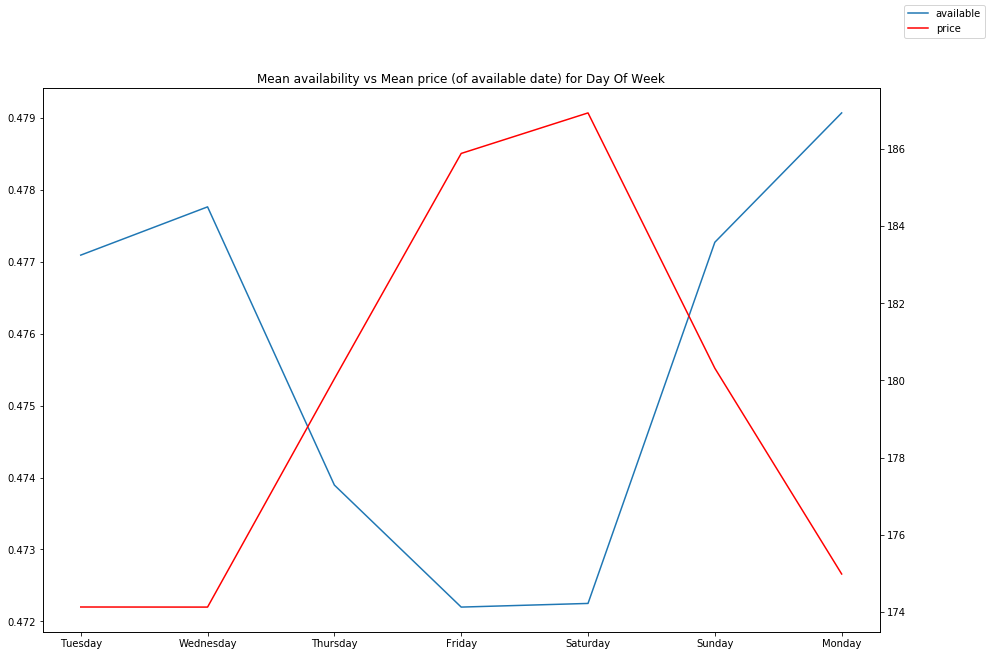

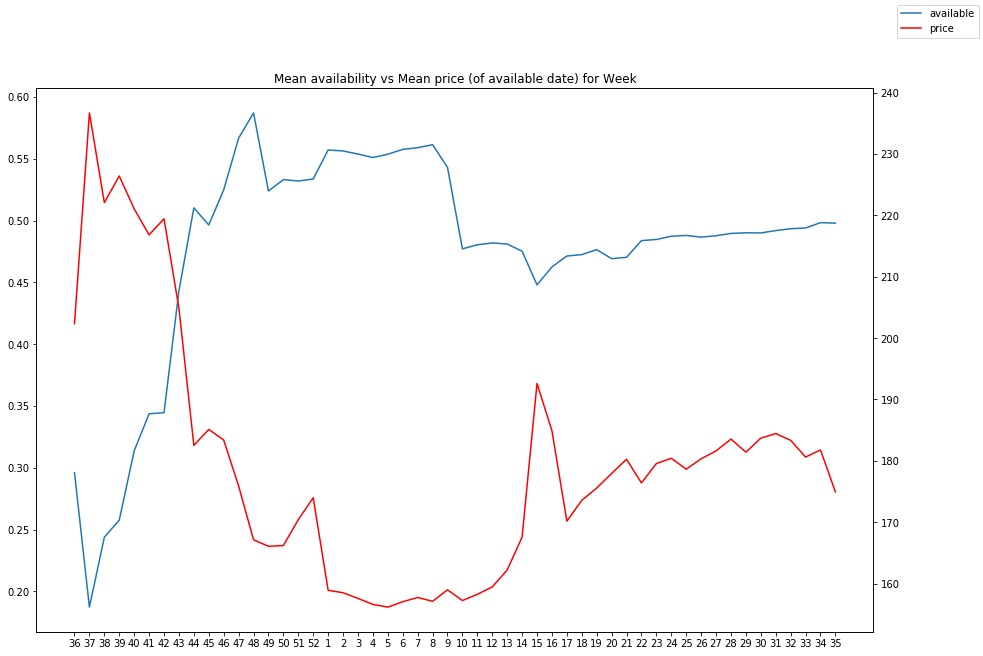

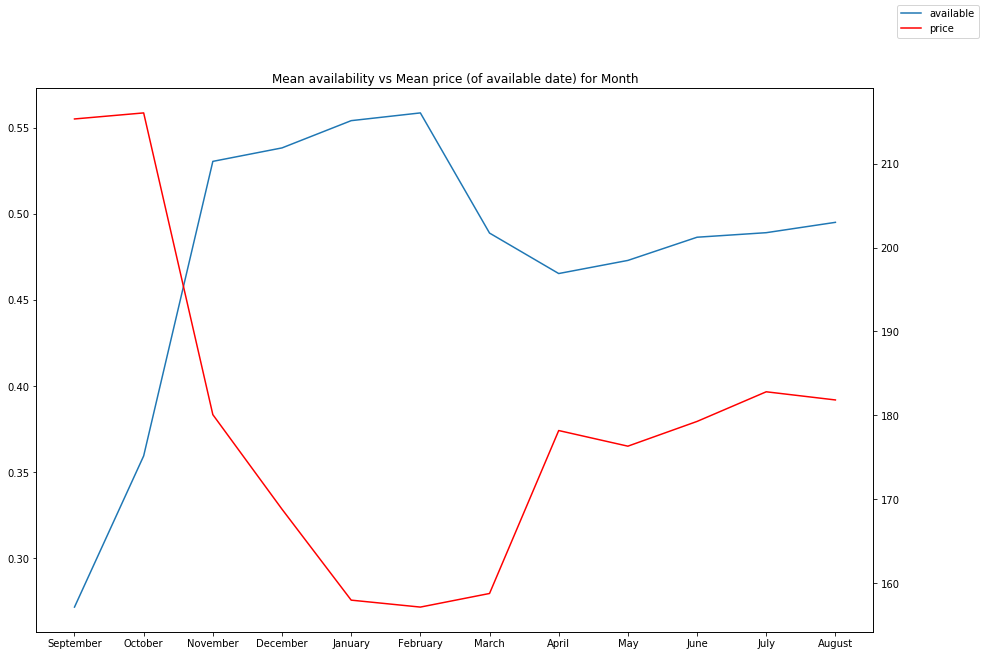

In [137]:
cat2_listing_available_in_date_df = grouby_date_cat2.copy()
cat2_listing_available_in_date_df['dayofweek'] = grouby_date_cat2.index.day_name()
cat2_listing_available_in_date_df['week'] = grouby_date_cat2.index.week
cat2_listing_available_in_date_df['month'] = grouby_date_cat2.index.month_name()
#cat2_listing_available_in_date_df.head(20)
plot_price_and_avail_per_aggregation(cat2_listing_available_in_date_df, 'dayofweek', 'Day Of Week')
plot_price_and_avail_per_aggregation(cat2_listing_available_in_date_df, 'week', 'Week')
plot_price_and_avail_per_aggregation(cat2_listing_available_in_date_df, 'month', 'Month')

#### Fo the MID caregory, the weekly prices during the spring-break is much lower than the Oct-Noc spike. With a wide range of lower prices: first 12 weeks of the year.

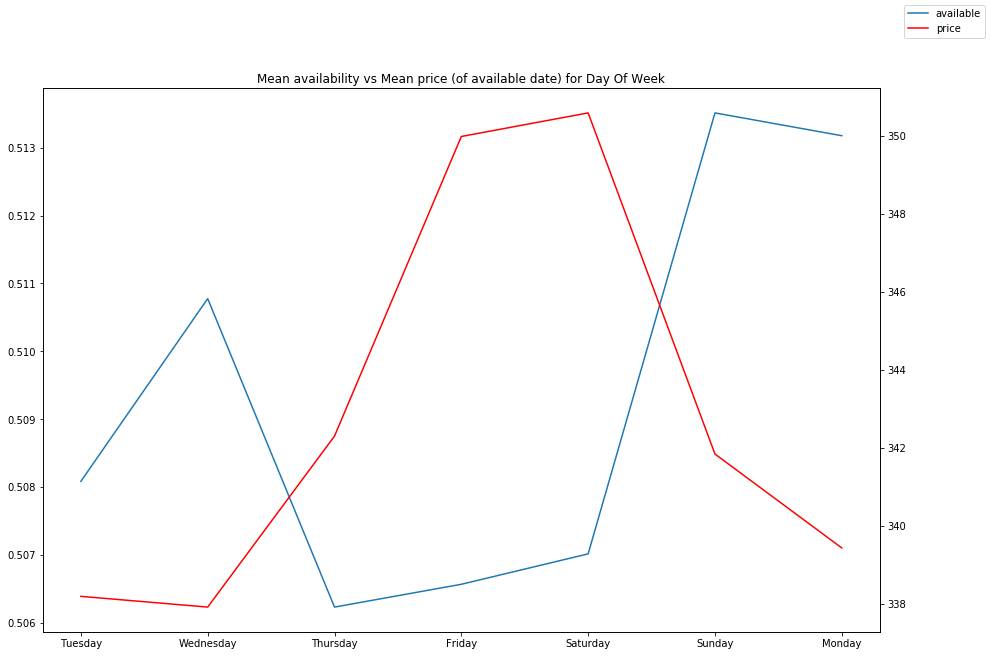

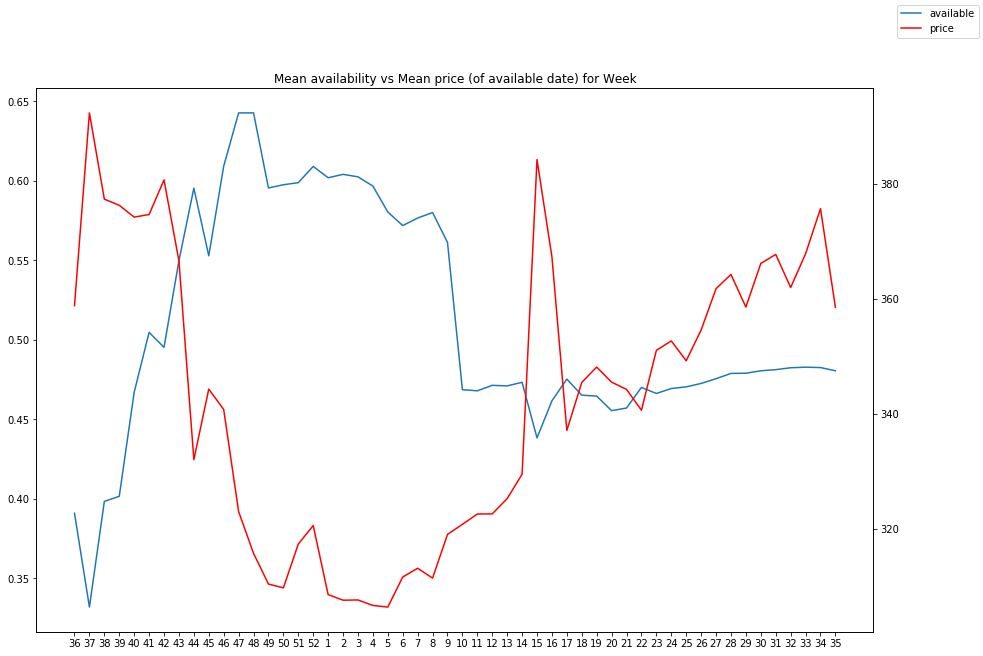

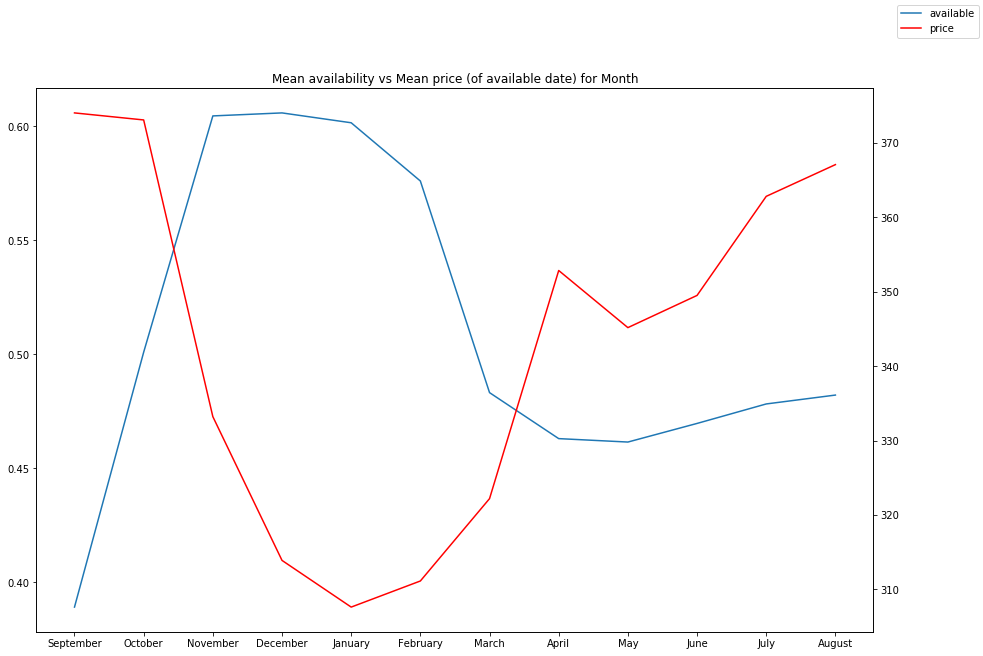

In [136]:
cat3_listing_available_in_date_df = grouby_date_cat3.copy()
cat3_listing_available_in_date_df['dayofweek'] = grouby_date_cat3.index.day_name()
cat3_listing_available_in_date_df['week'] = grouby_date_cat3.index.week
cat3_listing_available_in_date_df['month'] = grouby_date_cat3.index.month_name()
#cat3_listing_available_in_date_df.head(20)
plot_price_and_avail_per_aggregation(cat3_listing_available_in_date_df, 'dayofweek', 'Day Of Week')
plot_price_and_avail_per_aggregation(cat3_listing_available_in_date_df, 'week', 'Week')
plot_price_and_avail_per_aggregation(cat3_listing_available_in_date_df, 'month', 'Month')

#### Fo the HIGH caregory, the weekly prices during the spring-break is almost high as the Sep-Oct spike. With a reduced range of lower prices, respect both LOW and MID categories: first 3/4 weeks of the year.

### Find max/min prices in each category

In [156]:
# absolute price max for each cats
print("\nOverall max per cat:")
print(f"Cat 1 maxs: {grouby_date_cat1.nlargest(n=3, columns='price')['price']}")
print(f"Cat 2 maxs: {grouby_date_cat2.nlargest(n=3, columns='price')['price']}")
print(f"Cat 3 maxs: {grouby_date_cat3.nlargest(n=3, columns='price')['price']}")
# absolute price min for each cats
print("\nOverall min per cat:")
print(f"Cat 1 mins: {grouby_date_cat1.nsmallest(n=3, columns='price')['price']}")
print(f"Cat 2 mins: {grouby_date_cat2.nsmallest(n=3, columns='price')['price']}")
print(f"Cat 3 mins: {grouby_date_cat3.nsmallest(n=3, columns='price')['price']}")
cat_1_min_abs = grouby_date_cat1.min()['price']
cat_2_min_abs = grouby_date_cat2.min()['price']
cat_3_min_abs = grouby_date_cat3.min()['price']
# find minimum at least 1 week before 2017-04-14
print("\nWeek before spring-break (2017-04-15) min per cat:")
cat_1_min = grouby_date_cat1["2017-04-08":"2017-04-15"].min()['price']
print(f"Cat 1 min in previous week: {cat_1_min:.2f}")
cat_2_min = grouby_date_cat2["2017-04-08":"2017-04-15"].min()['price']
print(f"Cat 2 min in previous week: {cat_2_min:.2f}")
cat_3_min = grouby_date_cat3["2017-04-08":"2017-04-15"].min()['price']
print(f"Cat 3 min in previous week: {cat_3_min:.2f}")
cat_1_max_in_spike = grouby_date_cat1["2017-04-08":"2017-04-15"].max()['price']
cat_2_max_in_spike = grouby_date_cat2["2017-04-08":"2017-04-15"].max()['price']
cat_3_max_in_spike = grouby_date_cat3["2017-04-08":"2017-04-15"].max()['price']
print(f"Max in spring-break week: {cat_1_max_in_spike:.2f}/{cat_2_max_in_spike:.2f}/{cat_3_max_in_spike:.2f}")
print(f"Cat 1 % chage (min abs): {100 * (cat_1_max_in_spike / cat_1_min_abs - 1):.2f}%")
print(f"Cat 2 % chage (min abs): {100 * (cat_2_max_in_spike / cat_2_min_abs - 1):.2f}%")
print(f"Cat 3 % chage (min abs): {100 * (cat_3_max_in_spike / cat_3_min_abs - 1):.2f}%")
print(f"Cat 1 % chage (min in spike week): {100 * (cat_1_max_in_spike / cat_1_min - 1):.2f}%")
print(f"Cat 2 % chage (min in spike week): {100 * (cat_2_max_in_spike / cat_2_min - 1):.2f}%")
print(f"Cat 3 % chage (min in spike week): {100 * (cat_3_max_in_spike / cat_3_min - 1):.2f}%")


Overall max per cat:
Cat 1 maxs: date
2016-10-26    89.087034
2016-09-06    82.776860
2016-10-29    81.781250
Name: price, dtype: float64
Cat 2 maxs: date
2016-09-17    265.691919
2016-09-16    259.653266
2016-10-01    247.199248
Name: price, dtype: float64
Cat 3 maxs: date
2017-04-15    443.332627
2017-04-16    441.766094
2017-04-17    436.138298
Name: price, dtype: float64

Overall min per cat:
Cat 1 mins: date
2017-01-03    73.227811
2017-01-02    73.297619
2017-01-10    73.380466
Name: price, dtype: float64
Cat 2 mins: date
2017-03-07    152.568266
2017-03-06    152.716667
2017-03-14    153.051565
Name: price, dtype: float64
Cat 3 mins: date
2017-01-31    302.934540
2017-01-30    303.618384
2017-02-01    303.997089
Name: price, dtype: float64

Week before spring-break (2017-04-15) min per cat:
Cat 1 min in previous week: 77.49
Cat 2 min in previous week: 164.95
Cat 3 min in previous week: 328.24
Max in spring-break week: 81.02/224.57/443.33
Cat 1 % chage (min abs): 10.64%
Cat 2 % 

### Find max/min availability in each category

In [161]:
# absolute avail max for each cats
print("\nOverall max per cat:")
print(f"Cat 1 maxs: {grouby_date_cat1.nlargest(n=3, columns='available')['available']}")
print(f"Cat 2 maxs: {grouby_date_cat2.nlargest(n=3, columns='available')['available']}")
print(f"Cat 3 maxs: {grouby_date_cat3.nlargest(n=3, columns='available')['available']}")
# absolute avail min for each cats
print("\nOverall min per cat:")
print(f"Cat 1 mins: {grouby_date_cat1.nsmallest(n=3, columns='available')['available']}")
print(f"Cat 2 mins: {grouby_date_cat2.nsmallest(n=3, columns='available')['available']}")
print(f"Cat 3 mins: {grouby_date_cat3.nsmallest(n=3, columns='available')['available']}")
cat_1_max_abs = grouby_date_cat1.max()['available']
cat_2_max_abs = grouby_date_cat2.max()['available']
cat_3_max_abs = grouby_date_cat3.max()['available']
# find minimum at least 1 week before 2017-04-14
print("\nWeek before spring-break (2017-04-15) max per cat:")
cat_1_max = grouby_date_cat1["2017-04-08":"2017-04-15"].max()['available']
print(f"Cat 1 max in previous week: {cat_1_max:.2f}")
cat_2_max = grouby_date_cat2["2017-04-08":"2017-04-15"].max()['available']
print(f"Cat 2 max in previous week: {cat_2_max:.2f}")
cat_3_max = grouby_date_cat3["2017-04-08":"2017-04-15"].max()['available']
print(f"Cat 3 max in previous week: {cat_3_max:.2f}")
cat_1_min_in_spike = grouby_date_cat1["2017-04-08":"2017-04-15"].min()['available']
cat_2_min_in_spike = grouby_date_cat2["2017-04-08":"2017-04-15"].min()['available']
cat_3_min_in_spike = grouby_date_cat3["2017-04-08":"2017-04-15"].min()['available']
print(f"Min in spring-break week: {cat_1_min_in_spike:.2f}/{cat_2_min_in_spike:.2f}/{cat_3_min_in_spike:.2f}")
print(f"Cat 1 % chage (max abs): {100 * (cat_1_min_in_spike / cat_1_max_abs - 1):.2f}%")
print(f"Cat 2 % chage (max abs): {100 * (cat_2_min_in_spike / cat_2_max_abs - 1):.2f}%")
print(f"Cat 3 % chage (max abs): {100 * (cat_3_min_in_spike / cat_3_max_abs - 1):.2f}%")
print(f"Cat 1 % chage (max in spike week): {100 * (cat_1_min_in_spike / cat_1_max - 1):.2f}%")
print(f"Cat 2 % chage (max in spike week): {100 * (cat_2_min_in_spike / cat_2_max - 1):.2f}%")
print(f"Cat 3 % chage (max in spike week): {100 * (cat_3_min_in_spike / cat_3_max - 1):.2f}%")


Overall max per cat:
Cat 1 maxs: date
2016-12-04    0.586262
2016-12-03    0.575879
2016-12-02    0.570288
Name: available, dtype: float64
Cat 2 maxs: date
2016-12-04    0.607237
2016-12-03    0.597529
2016-12-02    0.594881
Name: available, dtype: float64
Cat 3 maxs: date
2016-12-04    0.653622
2016-11-27    0.652789
2016-11-26    0.651124
Name: available, dtype: float64

Overall min per cat:
Cat 1 mins: date
2016-09-06    0.096645
2016-09-07    0.158147
2016-09-16    0.163738
Name: available, dtype: float64
Cat 2 mins: date
2016-09-15    0.172109
2016-09-14    0.172992
2016-09-17    0.174757
Name: available, dtype: float64
Cat 3 mins: date
2016-09-06    0.207327
2016-09-15    0.300583
2016-09-16    0.303913
Name: available, dtype: float64

Week before spring-break (2017-04-15) max per cat:
Cat 1 max in previous week: 0.51
Cat 2 max in previous week: 0.48
Cat 3 max in previous week: 0.48
Min in spring-break week: 0.48/0.42/0.39
Cat 1 % chage (max abs): -18.12%
Cat 2 % chage (max abs)

### Q1: How the price rates changes during over the year? Local maximum/minimum or spike?

### A1: 
As show above, the lower prices are always in the firs weeks of the year. Then follows a slowly increasing trend till 2017-04-15 (spring break). After this price high and almost constant.

## What affect the prices among properties/categories? 


In [162]:
# "list" amenities per properties are available. The columns "amenities" is categorical, 
# and each cell for listing is a pseudo json/list.
# the operation to extract a usable list are: a) split, b) remove open and close "{" "}" at start and end, 
# c) fix double/single quotes: example '" converted to '
print("Examples of cell for amenities:")
print(df_boston_listings['amenities'].iloc[0])
list_vars = df_boston_listings['amenities'].iloc[0].split(",")
list_vars[0] = list_vars[0][1:]
list_vars[-1] = list_vars[-1][:-1]
# example of fix double/single quote
print("\nFix double/single quotes, example:")
print(list_vars[1], "->", list_vars[1].replace('"', ""))


Examples of cell for amenities:
{TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"}

Fix double/single quotes, example:
"Wireless Internet" -> Wireless Internet


In [163]:
# To be usafull we need at first a list of all the avaialble values. To get this must parse the listings dataset
# Then, create a column for each variable and asign 1 for the listings that have the specific amenity
# need to create a dedicate colums to use it
# at first get a list of all possible variables

def convert_pseudo_json_to_list(pseudo_json):
    # from josn/list to list
    
    list_vars = pseudo_json.split(",")
    list_vars[0] = list_vars[0][1:]
    list_vars[-1] = list_vars[-1][:-1]
    
    for i in range(len(list_vars)):
        list_vars[i] = list_vars[i].replace('"', "")  # fix '"example"' to 'example'
    
    # remove erroneous values
    if "translation missing: en.hosting_amenity_49" in list_vars:
        list_vars.remove("translation missing: en.hosting_amenity_49")
    if "translation missing: en.hosting_amenity_50" in list_vars:
        list_vars.remove("translation missing: en.hosting_amenity_50")
    if "" in list_vars:
        list_vars.remove("")
    
    return list_vars

def get_unique_variables_in_amenities(col):
    # return lsit of unique values
    
    available_variables = list()
    
    for value in col:
        list_vars = convert_pseudo_json_to_list(value)
    
        for each in list_vars:
            if each not in available_variables:
                available_variables.append(each)
    
    return available_variables


def convert_amenities_column_to_multiple_quantitative_columns(col):
    # Convert categorical variable into dummy/indicator variables. 
    
    available_amenities = get_unique_variables_in_amenities(col)
    
    output_df = pd.DataFrame(index=col.index, columns=available_amenities).fillna(0)
    
    for index in output_df.index:
        list_vars = convert_pseudo_json_to_list(col.loc[index])
        
        output_df.loc[index, list_vars] = 1
        #print(list_vars)
    
    return output_df
    


amenities_continuous_df = convert_amenities_column_to_multiple_quantitative_columns(df_boston_listings['amenities'])
df_boston_listings_fixed = df_boston_listings.drop(columns='amenities')
df_boston_listings_fixed = df_boston_listings_fixed.join(amenities_continuous_df)
df_boston_listings_fixed.head()
amenities_continuous_df.head()

,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,Washer,Dryer,...,Other pet(s),Washer / Dryer,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
# use dummies for amenities and add listing ids
amenities_continuous_df_join = amenities_continuous_df.join(df_boston_listings_fixed['id'])

# percentage of a specific amenity in each category 
cat_1_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat1_listings)].mean()
cat_2_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat2_listings)].mean()
cat_3_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat3_listings)].mean()
cat_1_perc_amenities.drop(index='id', inplace=True)
cat_2_perc_amenities.drop(index='id', inplace=True)
cat_3_perc_amenities.drop(index='id', inplace=True)

cat_1_perc_amenities.rename('cat_1_perc', inplace=True)
cat_2_perc_amenities.rename('cat_2_perc', inplace=True)
cat_3_perc_amenities.rename('cat_3_perc', inplace=True)

# plot # percentage of a specific amenity in each category and difference/comparison among the 3 categories
comp_df = pd.merge(cat_1_perc_amenities, cat_2_perc_amenities, left_index=True, right_index=True)
comp_df = pd.merge(comp_df, cat_3_perc_amenities, left_index=True, right_index=True)
comp_df['Diff_Vals_1vs2'] = comp_df['cat_2_perc'] - comp_df['cat_1_perc']
comp_df['Diff_Vals_2vs3'] = comp_df['cat_3_perc'] - comp_df['cat_2_perc']
comp_df['Diff_Vals_1vs3'] = comp_df['cat_3_perc'] - comp_df['cat_1_perc']
comp_df.sort_values(by=['Diff_Vals_1vs3', 'Diff_Vals_2vs3', 'Diff_Vals_1vs2'], ascending=False, inplace=True)
comp_df.style.bar(subset=['Diff_Vals_1vs2', 'Diff_Vals_2vs3', 'Diff_Vals_1vs3'], align='mid', color=['#d65f5f', '#5fba7d'])
#comp_df.style.bar(subset=['Diff_Vals_1vs2', 'Diff_Vals_2vs3'], align='mid', color=['#d65f5f', '#5fba7d'])
# the plot report the percentage of the presence of the specific in all the listings for a category, 
# together with the comparison against anotehr category.

,cat_1_perc,cat_2_perc,cat_3_perc,Diff_Vals_1vs2,Diff_Vals_2vs3,Diff_Vals_1vs3
Cable TV,0.274760,0.522507,0.695000,0.247746,0.172493,0.420240
TV,0.502396,0.779347,0.912500,0.276951,0.133153,0.410104
Family/Kid Friendly,0.353834,0.527802,0.705833,0.173968,0.178031,0.351999
Elevator in Building,0.099042,0.212710,0.419167,0.113668,0.206457,0.320125
Air Conditioning,0.605431,0.845543,0.920833,0.240111,0.075291,0.315402
Gym,0.034345,0.112092,0.257500,0.077747,0.145408,0.223155
Internet,0.612620,0.725508,0.823333,0.112888,0.097826,0.210714
24-Hour Check-in,0.245208,0.357458,0.445833,0.112250,0.088375,0.200626
Iron,0.420128,0.502207,0.610833,0.082079,0.108627,0.190706
Dryer,0.623003,0.667255,0.783333,0.044252,0.116078,0.160330


In [189]:
# neighbourhood
cat1_neigh = df_boston_listings[df_boston_listings['id'].isin(cat1_listings)]['neighbourhood'].value_counts()
cat1_neigh /= cat1_neigh.sum()
cat2_neigh = df_boston_listings[df_boston_listings['id'].isin(cat2_listings)]['neighbourhood'].value_counts()
cat2_neigh /= cat2_neigh.sum()
cat3_neigh = df_boston_listings[df_boston_listings['id'].isin(cat3_listings)]['neighbourhood'].value_counts()
cat3_neigh /= cat3_neigh.sum()

cat1_neigh.rename('cat_1_perc', inplace=True)
cat2_neigh.rename('cat_2_perc', inplace=True)
cat3_neigh.rename('cat_3_perc', inplace=True)

comp_df = pd.merge(cat1_neigh, cat2_neigh, left_index=True, right_index=True)
comp_df = pd.merge(comp_df, cat3_neigh, left_index=True, right_index=True)
comp_df['Diff_Vals_1vs2'] = comp_df['cat_2_perc'] - comp_df['cat_1_perc']
comp_df['Diff_Vals_2vs3'] = comp_df['cat_3_perc'] - comp_df['cat_2_perc']
comp_df['Diff_Vals_1vs3'] = comp_df['cat_3_perc'] - comp_df['cat_1_perc']
comp_df.sort_values(by=['Diff_Vals_1vs3', 'Diff_Vals_2vs3', 'Diff_Vals_1vs2'], ascending=False, inplace=True)
comp_df.style.bar(subset=['Diff_Vals_1vs2', 'Diff_Vals_2vs3', 'Diff_Vals_1vs3'], align='mid', color=['#d65f5f', '#5fba7d'])
# the plot report the percentage of the presence of property in a specific neighbourhood 
# together with the comparison against another category.

,cat_1_perc,cat_2_perc,cat_3_perc,Diff_Vals_1vs2,Diff_Vals_2vs3,Diff_Vals_1vs3
Back Bay,0.018812,0.103061,0.162548,0.084249,0.059486,0.143736
South End,0.030693,0.142857,0.120722,0.112164,-0.022135,0.090029
Beacon Hill,0.012871,0.081633,0.076996,0.068761,-0.004636,0.064125
Fenway/Kenmore,0.059406,0.062245,0.121673,0.002839,0.059428,0.062267
South Boston,0.029703,0.091837,0.091255,0.062134,-0.000582,0.061552
Chinatown,0.002970,0.020408,0.052281,0.017438,0.031873,0.049311
North End,0.008911,0.066327,0.048479,0.057416,-0.017847,0.039568
Charlestown,0.008911,0.033673,0.035171,0.024763,0.001498,0.026260
Downtown Crossing,0.000990,0.002041,0.021863,0.001051,0.019822,0.020873
Theater District,0.001980,0.013265,0.017110,0.011285,0.003845,0.015130


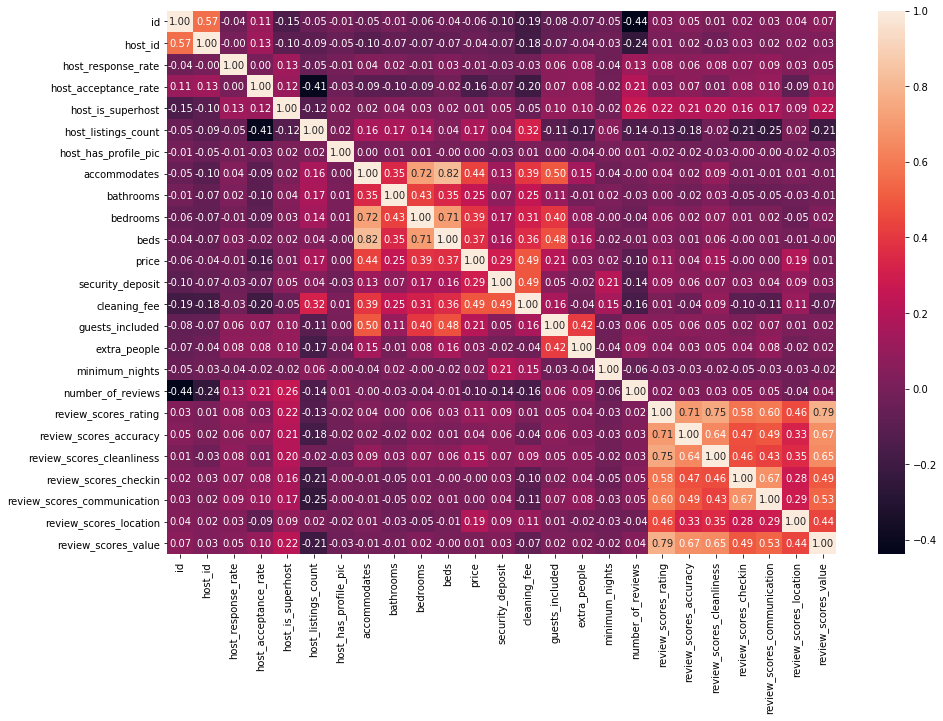

In [190]:
# correlatin matrix
sns.heatmap(df_boston_listings.corr(), annot=True, fmt=".2f");

In [197]:
# check correlatins against price, just for numerical columns
df_boston_listings.corr()['price'].abs().sort_values(ascending=False)
# conferm that at least 5 entry have a corr > 0.25,and 2 > 0.5

price                          1.000000
cleaning_fee                   0.490210
accommodates                   0.437756
bedrooms                       0.385298
beds                           0.370013
security_deposit               0.292426
bathrooms                      0.248234
guests_included                0.211806
review_scores_location         0.193928
host_listings_count            0.171930
host_acceptance_rate           0.156908
review_scores_cleanliness      0.146548
review_scores_rating           0.105651
number_of_reviews              0.096427
id                             0.059198
review_scores_accuracy         0.041204
host_id                        0.040043
extra_people                   0.028703
minimum_nights                 0.020054
review_scores_value            0.011834
host_response_rate             0.007750
host_is_superhost              0.006054
review_scores_checkin          0.003851
review_scores_communication    0.003614
host_has_profile_pic           0.000893


## Q2: Anythings about the properties that affects the base price rates?
Amenities seem to have a huge impact over price rates, at least for the selected categories.
The table/plot allows to have a clear understand of what is considered important for pay/requires an higher price. It is intresting to notice that "allow animals" is a negative factor over price (Cat, Dog, and Pets live on the propery), first aid kit not such important. But really important is to have Cable TV, Elevator, A/C, Internet and much more. Now, letue these information to predict base price for properties.  

In [204]:
df_boston_listings_fixed.columns

# fix categorical before
#Pull a list of the column names of the categorical variables
    cat_df = X.select_dtypes(include=['object'])
    cat_cols = cat_df.columns

    #dummy all the cat_cols
    for col in  cat_cols:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)


Index(['id', 'last_scraped', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'TV', 'Wireless Internet', 'Kitchen',
       'Free Parking on Premises', 'Pets live on this property', 'Dog(s)',
       'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector',
 

In [257]:
# predict price using amenitis avaialble, first of all create a  function to:
# 1) get as input explanatory and price (target) variables
# 2) Split into train and test
# 3) fit a model
# 4) Predict using your model
# 5) Comput scores

def fit_linear_mod(X, y, test_size=.3, rand_state=42, fill='drop'):
    
    ##Pull a list of the column names of the categorical variables
    #cat_df = X.select_dtypes(include=['object'])
    #cat_cols = cat_df.columns

    #dummy all the cat_cols
    #for col in  cat_cols:
    #    X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

    # Mean function
    if fill == 'mean':
        fill_mean = lambda col: col.fillna(col.mean())
        # Fill the mean
        X = X.apply(fill_mean, axis=0)
        
    elif fill == 'zero':
        X = X.fillna(0)
    
    elif fill == 'drop':
        # need to remove rows also form y
        nan_indexes = X[X.isna().sum(axis=1) > 0].index
        y = y.drop(nan_indexes)
        X = X.drop(nan_indexes)
        #X = X.dropna(axis=0, how='any')
    
    #print(X.isna().mean() != 0)
        
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    #Fit model
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    return X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test


print("Prediction wiht mean to replace nan")
# first try: drop all categorical
cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
cat_cols = list(cat_df.columns)

cat_cols.append('price')
# set explanatory and price (target)
X = df_boston_listings_fixed.drop(columns=cat_cols)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='mean')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")


# fix categorical: host_location, host_response_time, host_neighbourhood, property_type, host_verifications, host_identity_verified
# , neighbourhood, property_type, room_type, bed_type, instant_bookable, cancellation_policy
# drop categorical: last_scraped, host_since

cat_to_drop = ['host_location', 'last_scraped', 'host_since']
cat_to_fix = ['host_response_time', 'host_neighbourhood', 'property_type', 'host_verifications',
              'host_identity_verified', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 
              'instant_bookable', 'cancellation_policy']

df_boston_listings_fixed2 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed2[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

cat_to_drop.append('price')

# set explanatory and price (target)
X = df_boston_listings_fixed2.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed2['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='mean')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")

# predict cats
df_boston_listings_fixed3 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed3.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed3[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

df_boston_listings_fixed3['cat'] = 0
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat1_listings)] = 1
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat2_listings)] = 2
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat3_listings)] = 3

cat_to_drop.append('price')
cat_to_drop.append('cat')

# set explanatory and price (target)
X = df_boston_listings_fixed3.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed3['cat']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='mean')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")
print(f"Train len: {len(X_train)}")

Prediction wiht mean to replace nan
Test r2-score: 0.23166107363516764
Train r2-score: 0.3792866690487374
Test r2-score: 0.24800711640123507
Train r2-score: 0.4079479820837203
Test r2-score: 0.5954418262428076
Train r2-score: 0.6159681384126905
Train len: 2509


/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [258]:
print("Prediction wiht zeros to replace nan")
# first try: drop all categorical
cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
cat_cols = list(cat_df.columns)

cat_cols.append('price')
# set explanatory and price (target)
X = df_boston_listings_fixed.drop(columns=cat_cols)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='zero')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")


# fix categorical: host_location, host_response_time, host_neighbourhood, property_type, host_verifications, host_identity_verified
# , neighbourhood, property_type, room_type, bed_type, instant_bookable, cancellation_policy
# drop categorical: last_scraped, host_since

cat_to_drop = ['host_location', 'last_scraped', 'host_since']
cat_to_fix = ['host_response_time', 'host_neighbourhood', 'property_type', 'host_verifications',
              'host_identity_verified', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 
              'instant_bookable', 'cancellation_policy']

df_boston_listings_fixed2 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed2[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

cat_to_drop.append('price')

# set explanatory and price (target)
X = df_boston_listings_fixed2.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed2['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='zero')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")

# predict cats
df_boston_listings_fixed3 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed3.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed3[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

df_boston_listings_fixed3['cat'] = 0
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat1_listings)] = 1
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat2_listings)] = 2
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat3_listings)] = 3

cat_to_drop.append('price')
cat_to_drop.append('cat')

# set explanatory and price (target)
X = df_boston_listings_fixed3.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed3['cat']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='zero')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")
print(f"Train len: {len(X_train)}")

Prediction wiht zeros to replace nan
Test r2-score: 0.2278272069065227
Train r2-score: 0.37754040438451353
Test r2-score: 0.2468188123064614
Train r2-score: 0.40656749774135703


/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Test r2-score: 0.5929092440305932
Train r2-score: 0.6154832958755794
Train len: 2509


/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [259]:
print("Prediction wih drop nan rows")
# first try: drop all categorical
cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
cat_cols = list(cat_df.columns)

cat_cols.append('price')
# set explanatory and price (target)
X = df_boston_listings_fixed.drop(columns=cat_cols)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='drop')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")


# fix categorical: host_location, host_response_time, host_neighbourhood, property_type, host_verifications, host_identity_verified
# , neighbourhood, property_type, room_type, bed_type, instant_bookable, cancellation_policy
# drop categorical: last_scraped, host_since

cat_to_drop = ['host_location', 'last_scraped', 'host_since']
cat_to_fix = ['host_response_time', 'host_neighbourhood', 'property_type', 'host_verifications',
              'host_identity_verified', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 
              'instant_bookable', 'cancellation_policy']

df_boston_listings_fixed2 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed2[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

cat_to_drop.append('price')

# set explanatory and price (target)
X = df_boston_listings_fixed2.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed2['price']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='drop')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")

# predict cats
df_boston_listings_fixed3 = df_boston_listings_fixed.copy()

cat_df = df_boston_listings_fixed3.select_dtypes(include=['object'])
for cat_col in cat_to_fix:
    # print(cat_col)
    # print(df_boston_listings_fixed[cat_col].iloc[0:3])
    df_boston_listings_fixed3[cat_col] = pd.Categorical(df_boston_listings_fixed2[cat_col].values).codes

df_boston_listings_fixed3['cat'] = 0
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat1_listings)] = 1
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat2_listings)] = 2
df_boston_listings_fixed3['cat'][df_boston_listings_fixed3['id'].isin(cat3_listings)] = 3

cat_to_drop.append('price')
cat_to_drop.append('cat')

# set explanatory and price (target)
X = df_boston_listings_fixed3.drop(columns=cat_to_drop)
#categorical_df = df_non_categorical = df_non_categorical.drop(columns=['price', 'weekly_price', 'monthly_price', ])
y = df_boston_listings_fixed3['cat']
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(X, y, fill='drop')
    
print(f"Test r2-score: {test_score}")
print(f"Train r2-score: {train_score}")
print(f"Train len: {len(X_train)}")

Prediction wih drop nan rows
Test r2-score: 0.53529419983675
Train r2-score: 0.665142187586871
Test r2-score: 0.570705696237124
Train r2-score: 0.6970708506322717
Test r2-score: 0.5256052283471647
Train r2-score: 0.701152681102623
Train len: 654


/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marco/Workspace/Udacity/Data_Scientist_Nanodegree/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde